In [ ]:
from google.colab import files

uploaded = files.upload()  # This will prompt you to upload the file

Saving IDP_SER (1).zip to IDP_SER (1).zip


In [ ]:
import zipfile
import os

# Define file paths
zip_path = "/content/IDP_SER (1).zip"
extract_path = "/content/extracted"

# Create extraction folder if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

Files extracted to: /content/extracted


In [ ]:
!apt-get install -y libwebrtc-audio-processing-dev
!pip install webrtcvad-wheels

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libwebrtc-audio-processing1
The following NEW packages will be installed:
  libwebrtc-audio-processing-dev libwebrtc-audio-processing1
0 upgraded, 2 newly installed, 0 to remove and 30 not upgraded.
Need to get 651 kB of archives.
After this operation, 2,262 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libwebrtc-audio-processing1 amd64 0.3.1-0ubuntu5 [291 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libwebrtc-audio-processing-dev amd64 0.3.1-0ubuntu5 [360 kB]
Fetched 651 kB in 1s (483 kB/s)
Selecting previously unselected package libwebrtc-audio-processing1:amd64.
(Reading database ... 126213 files and directories currently installed.)
Preparing to unpack .../libwebrtc-audio-processing1_0.3.1-0ubuntu5_amd64.deb ...
Unpacking libwebrtc-audio-processing1:amd64 (0.3.1-0ubu

Processing Audio Files: 0it [00:00, ?it/s]
Processing Audio Files: 100%|██████████| 480/480 [00:38<00:00, 12.41it/s] 


Preprocessing completed successfully.


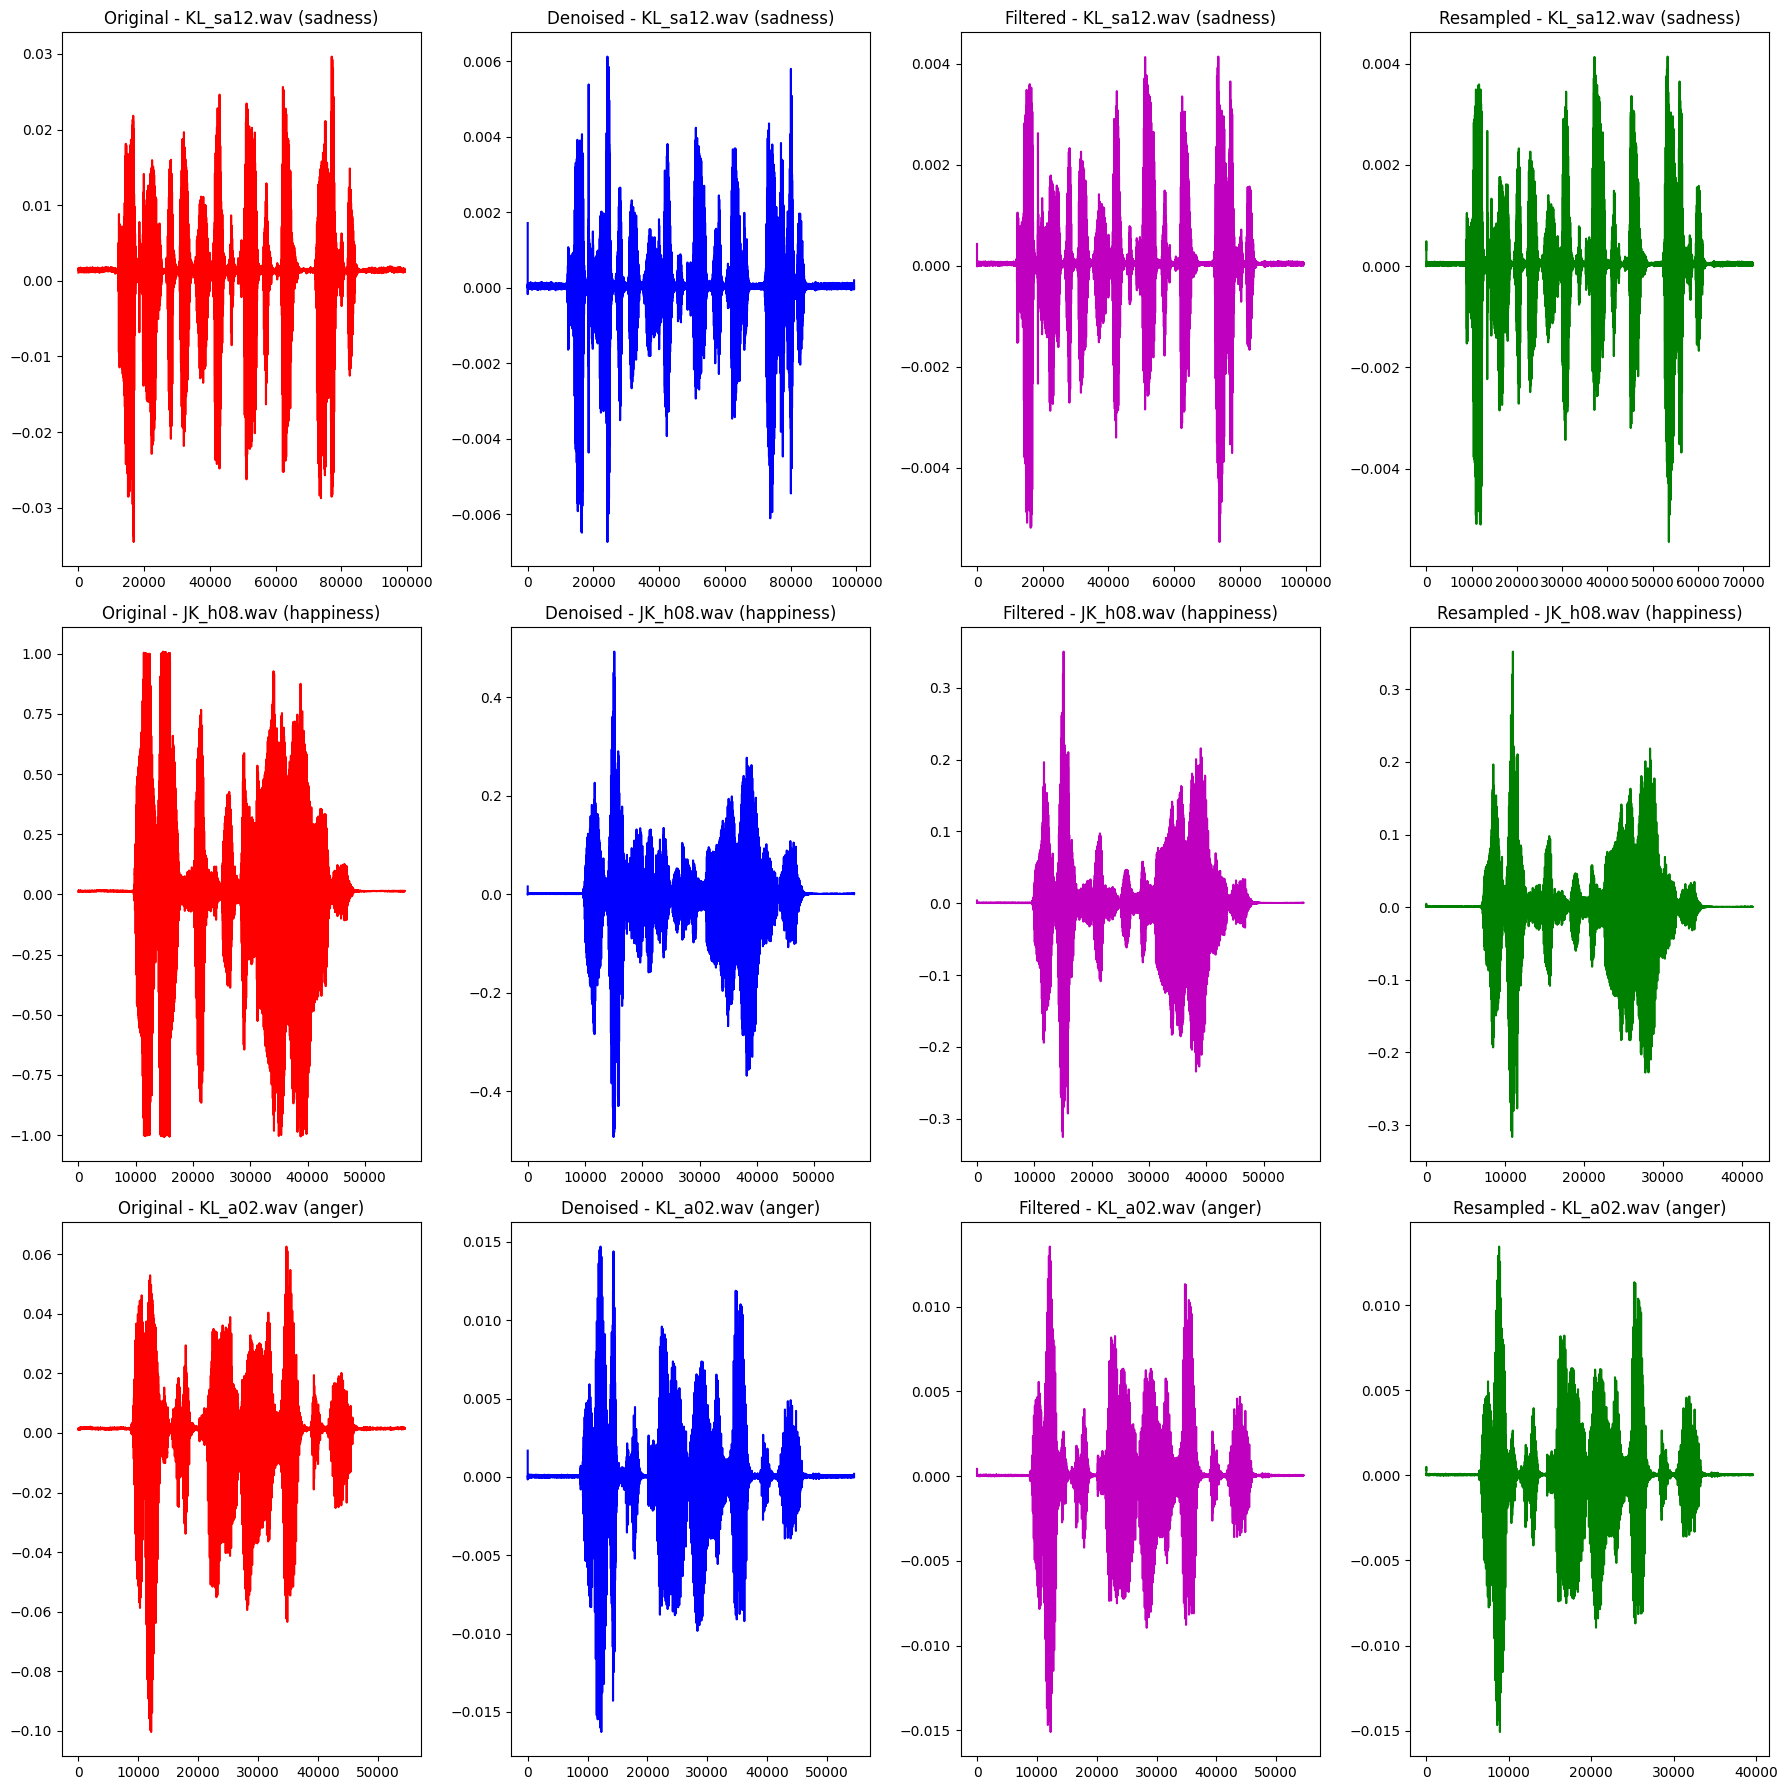

In [ ]:
import os
import librosa
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Correct Emotion Mapping
emotion_mapping = {
    'a': 'anger',
    'd': 'disgust',
    'f': 'fear',
    'h': 'happiness',
    'n': 'neutral',
    'sa': 'sadness',
    'su': 'surprise'
}

def remove_noise(y, sr):
    return librosa.effects.preemphasis(y)

def apply_filtering(y):
    kernel_size = 5
    kernel = np.ones(kernel_size) / kernel_size
    return np.convolve(y, kernel, mode='same')

def resample_audio(y, sr, target_sr=16000):
    return librosa.resample(y, orig_sr=sr, target_sr=target_sr), target_sr

# Paths
dataset_dir = "/content/extracted"
audio_output_dir = "/content/Preprocessed_Audiofiles"
text_output_dir = "/content/pre-Processed_Text"
train_dir = os.path.join(audio_output_dir, "train")
test_dir = os.path.join(audio_output_dir, "test")

# Ensure directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(text_output_dir, exist_ok=True)

processed_files = []

# Process dataset
for root, _, files in os.walk(dataset_dir):
    for file in tqdm(files, desc="Processing Audio Files"):
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)

            # Extract emotion from filename (corrected for SAVEE dataset format)
            filename_parts = file.split("_")
            emotion_code = filename_parts[-1].split(".")[0]  # Extract last part before .wav
            emotion_code = ''.join([i for i in emotion_code if not i.isdigit()])  # Remove digits

            emotion = emotion_mapping.get(emotion_code, "unknown")

            if emotion == "unknown":
                print(f"Warning: Emotion not identified correctly for file {file}. Expected one of {list(emotion_mapping.keys())}, but got '{emotion_code}'.")
                continue

            y, sr = librosa.load(file_path, sr=22050)
            y_denoised = remove_noise(y, sr)
            y_filtered = apply_filtering(y_denoised)
            y_resampled, new_sr = resample_audio(y_filtered, sr)

            processed_files.append((file, emotion, y, y_denoised, y_filtered, y_resampled, new_sr))

# Split data
if len(processed_files) > 0:
    train_files, test_files = train_test_split(processed_files, test_size=0.2, random_state=42)

    # Save processed files
    for file, emotion, _, _, _, y_resampled, new_sr in train_files:
        sf.write(os.path.join(train_dir, f"preprocessed_{file}"), y_resampled, new_sr)

    for file, emotion, _, _, _, y_resampled, new_sr in test_files:
        sf.write(os.path.join(test_dir, f"preprocessed_{file}"), y_resampled, new_sr)

    # Save file names
    with open(os.path.join(text_output_dir, "train_files.txt"), "w") as f:
        f.writelines("\n".join([f"{file},{emotion}" for file, emotion, _, _, _, _, _ in train_files]))

    with open(os.path.join(text_output_dir, "test_files.txt"), "w") as f:
        f.writelines("\n".join([f"{file},{emotion}" for file, emotion, _, _, _, _, _ in test_files]))

    print("Preprocessing completed successfully.")
else:
    print("Error: No valid audio files processed. Check file naming conventions.")

# Visualization
if len(processed_files) > 0:
    fig, axes = plt.subplots(min(3, len(train_files)), 4, figsize=(18, 6 * min(3, len(train_files))))
    for i, (filename, emotion, original, denoised, filtered, resampled, _) in enumerate(train_files[:3]):
        axes[i, 0].plot(original, color='r')
        axes[i, 0].set_title(f'Original - {filename} ({emotion})')

        axes[i, 1].plot(denoised, color='b')
        axes[i, 1].set_title(f'Denoised - {filename} ({emotion})')

        axes[i, 2].plot(filtered, color='m')
        axes[i, 2].set_title(f'Filtered - {filename} ({emotion})')

        axes[i, 3].plot(resampled, color='g')
        axes[i, 3].set_title(f'Resampled - {filename} ({emotion})')

    plt.tight_layout()
    plt.show()


In [ ]:
import os
import librosa
import numpy as np
import pickle
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm

# Correct Emotion Mapping
emotion_mapping = {
    'a': 'anger',
    'd': 'disgust',
    'f': 'fear',
    'h': 'happiness',
    'n': 'neutral',
    'sa': 'sadness',
    'su': 'surprise'
}

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)

    # Extract MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

    # Extract Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)

    # Extract Spectral Contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

    # CNN-compatible feature extraction (Mel Spectrogram)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    return mfccs, chroma, spectral_contrast, mel_spec_db

dataset_dir = "/content/Preprocessed_Audiofiles"
feature_output_file = "/content/features.pkl"
features = []
labels = []

# Process dataset
for root, _, files in os.walk(dataset_dir):
    for file in tqdm(files, desc="Extracting Features"):
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)

            # Extract emotion
            filename_parts = file.split("_")
            emotion_code = filename_parts[-1].split(".")[0]
            emotion_code = ''.join([i for i in emotion_code if not i.isdigit()])
            emotion = emotion_mapping.get(emotion_code, "unknown")

            if emotion == "unknown":
                print(f"Warning: Emotion not identified correctly for file {file}")
                continue

            # Extract features
            mfccs, chroma, spectral_contrast, mel_spec_db = extract_features(file_path)

            # Store features and labels
            features.append([mfccs, chroma, spectral_contrast, mel_spec_db])
            labels.append(emotion)

# Save extracted features
with open(feature_output_file, 'wb') as f:
    pickle.dump((features, labels), f)

print("Feature extraction completed and saved.")


Extracting Features: 0it [00:00, ?it/s]
Extracting Features: 100%|██████████| 384/384 [00:20<00:00, 19.10it/s]


Feature extraction completed and saved.


In [ ]:
import os
import librosa
import numpy as np
import pickle
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm

# Correct Emotion Mapping
emotion_mapping = {
    'a': 'anger',
    'd': 'disgust',
    'f': 'fear',
    'h': 'happiness',
    'n': 'neutral',
    'sa': 'sadness',
    'su': 'surprise'
}

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)

    # Extract MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

    # Extract Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)

    # Extract Spectral Contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

    # CNN-compatible feature extraction (Mel Spectrogram)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    return mfccs, chroma, spectral_contrast, mel_spec_db

dataset_dir = "/content/Preprocessed_Audiofiles"
feature_output_file = "/content/features.pkl"
features = []
labels = []

# Process dataset
for root, _, files in os.walk(dataset_dir):
    for file in tqdm(files, desc="Extracting Features"):
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)

            # Extract emotion
            filename_parts = file.split("_")
            emotion_code = filename_parts[-1].split(".")[0]
            emotion_code = ''.join([i for i in emotion_code if not i.isdigit()])
            emotion = emotion_mapping.get(emotion_code, "unknown")

            if emotion == "unknown":
                print(f"Warning: Emotion not identified correctly for file {file}")
                continue

            # Extract features
            mfccs, chroma, spectral_contrast, mel_spec_db = extract_features(file_path)

            # Store features and labels
            features.append([mfccs, chroma, spectral_contrast, mel_spec_db])
            labels.append(emotion)

# Save extracted features
with open(feature_output_file, 'wb') as f:
    pickle.dump((features, labels), f)

print("Feature extraction completed and saved.")

# Example of displaying file names as requested:
for root, _, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith(".wav"):
            filename_parts = file.split("_")
            emotion_code = filename_parts[-1].split(".")[0]
            emotion_code = ''.join([i for i in emotion_code if not i.isdigit()])
            emotion = emotion_mapping.get(emotion_code, "unknown")
            if emotion != "unknown":
                speaker = filename_parts[0]
                print(f"Extracting features: {file} | Speaker: {speaker} | Emotion: {emotion}")

Extracting Features: 0it [00:00, ?it/s]
Extracting Features: 100%|██████████| 384/384 [00:16<00:00, 22.75it/s]


Feature extraction completed and saved.
Extracting features: preprocessed_JK_a07.wav | Speaker: preprocessed | Emotion: anger
Extracting features: preprocessed_JK_f14.wav | Speaker: preprocessed | Emotion: fear
Extracting features: preprocessed_JK_f06.wav | Speaker: preprocessed | Emotion: fear
Extracting features: preprocessed_DC_h01.wav | Speaker: preprocessed | Emotion: happiness
Extracting features: preprocessed_DC_d03.wav | Speaker: preprocessed | Emotion: disgust
Extracting features: preprocessed_JE_d07.wav | Speaker: preprocessed | Emotion: disgust
Extracting features: preprocessed_JE_h10.wav | Speaker: preprocessed | Emotion: happiness
Extracting features: preprocessed_KL_n16.wav | Speaker: preprocessed | Emotion: neutral
Extracting features: preprocessed_JK_d03.wav | Speaker: preprocessed | Emotion: disgust
Extracting features: preprocessed_JK_n02.wav | Speaker: preprocessed | Emotion: neutral
Extracting features: preprocessed_JK_d10.wav | Speaker: preprocessed | Emotion: disg


⚡ Training SVM...
✅ SVM Accuracy: 86.31%
              precision    recall  f1-score   support

           0       0.76      0.83      0.79        23
           1       0.89      0.89      0.89        19
           2       0.89      0.96      0.93        26
           3       0.85      0.77      0.81        22
           4       0.80      0.83      0.82        24
           5       0.90      0.82      0.86        22
           6       0.94      0.91      0.92        32

    accuracy                           0.86       168
   macro avg       0.86      0.86      0.86       168
weighted avg       0.87      0.86      0.86       168



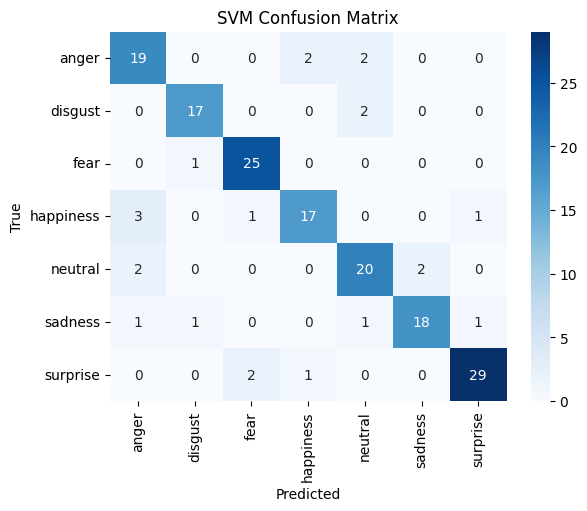


⚡ Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


✅ Logistic Regression Accuracy: 80.95%
              precision    recall  f1-score   support

           0       0.71      0.87      0.78        23
           1       0.73      0.84      0.78        19
           2       0.87      1.00      0.93        26
           3       0.82      0.82      0.82        22
           4       0.82      0.38      0.51        24
           5       1.00      0.82      0.90        22
           6       0.78      0.91      0.84        32

    accuracy                           0.81       168
   macro avg       0.82      0.80      0.80       168
weighted avg       0.82      0.81      0.80       168



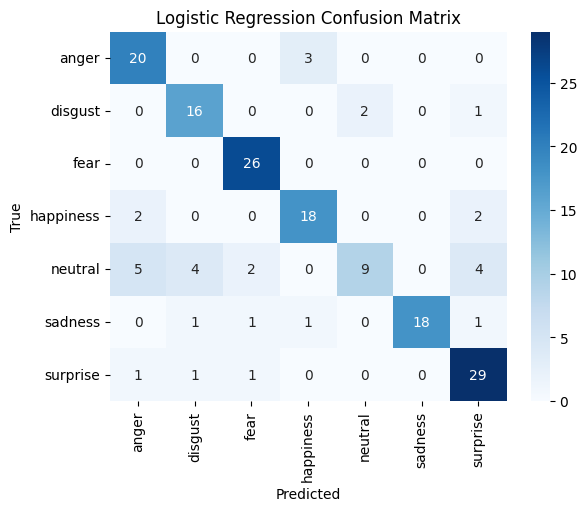


⚡ Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


✅ Random Forest Accuracy: 80.36%
              precision    recall  f1-score   support

           0       0.67      0.87      0.75        23
           1       0.87      0.68      0.76        19
           2       1.00      0.73      0.84        26
           3       0.78      0.82      0.80        22
           4       0.67      0.83      0.74        24
           5       0.87      0.91      0.89        22
           6       0.89      0.78      0.83        32

    accuracy                           0.80       168
   macro avg       0.82      0.80      0.80       168
weighted avg       0.83      0.80      0.81       168



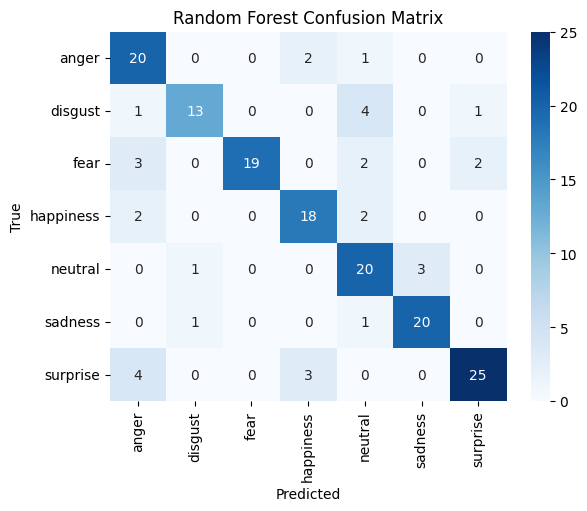


🔁 Training Stacked Ensemble...

✅ Stacked Accuracy: 86.90%
              precision    recall  f1-score   support

           0       0.95      0.83      0.88        23
           1       0.89      0.84      0.86        19
           2       0.89      0.96      0.93        26
           3       0.89      0.77      0.83        22
           4       0.69      0.92      0.79        24
           5       0.90      0.82      0.86        22
           6       0.94      0.91      0.92        32

    accuracy                           0.87       168
   macro avg       0.88      0.86      0.87       168
weighted avg       0.88      0.87      0.87       168



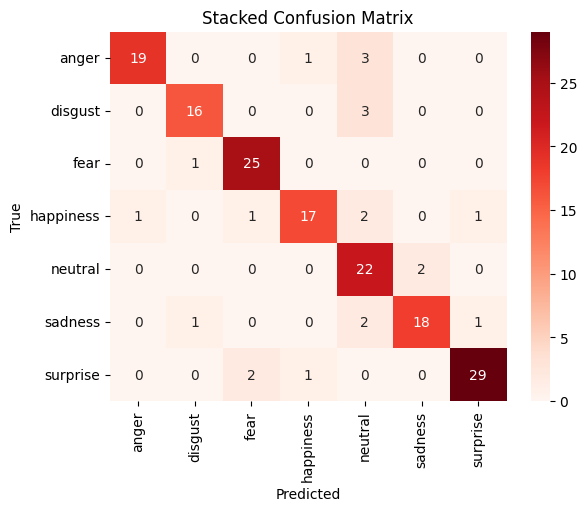

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

# Load preprocessed data
with open("/content/features.pkl", 'rb') as f:
    loaded_features, loaded_labels = pickle.load(f)

max_length = max([np.concatenate([f[0].flatten(), f[1].flatten(), f[2].flatten()]).size for f in loaded_features])
X = [np.pad(np.concatenate([f[0].flatten(), f[1].flatten(), f[2].flatten()]), (0, max_length - np.concatenate([f[0].flatten(), f[1].flatten(), f[2].flatten()]).size)) for f in loaded_features]
X = np.array(X)
y = LabelEncoder().fit_transform(loaded_labels)

# Scale + Balance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_resampled, y_resampled = SMOTE().fit_resample(X_scaled, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Param spaces (reduced)
param_spaces = {
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    "Logistic Regression": {
        'C': [0.1, 1, 10],
        'solver': ['liblinear']
    },
    "Random Forest": {
        'n_estimators': [100, 200],
        'max_depth': [10, None]
    }
}

# Models
models = {
    "SVM": SVC(probability=True, class_weight='balanced'),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier()
}

# Emotion Labels
emotion_labels = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

# Train Models with RandomizedSearchCV
best_models = {}
for name, model in models.items():
    print(f"\n⚡ Training {name}...")
    search = RandomizedSearchCV(model, param_spaces[name], n_iter=5, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    preds = search.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"✅ {name} Accuracy: {acc*100:.2f}%")
    print(classification_report(y_test, preds))
    sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Stacking Model
print("\n🔁 Training Stacked Ensemble...")
stack_model = StackingClassifier(
    estimators=[
        ('svm', best_models['SVM']),
        ('rf', best_models['Random Forest'])
    ],
    final_estimator=LogisticRegression(class_weight='balanced'),
    cv=3,
    n_jobs=-1
)
stack_model.fit(X_train, y_train)
y_stack = stack_model.predict(X_test)
stack_acc = accuracy_score(y_test, y_stack)
print(f"\n✅ Stacked Accuracy: {stack_acc*100:.2f}%")
print(classification_report(y_test, y_stack))
sns.heatmap(confusion_matrix(y_test, y_stack), annot=True, fmt='d', cmap='Reds',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title("Stacked Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Save Models
with open('ann.pkl', 'wb') as f:
    pickle.dump(stack_model, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


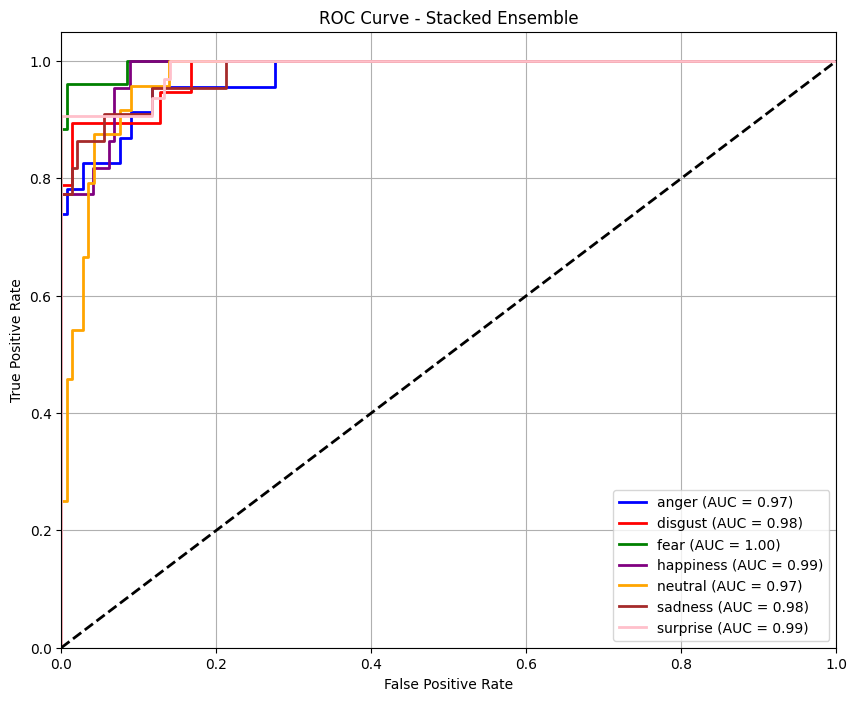

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

# Get predicted probabilities from stacked model
y_score = stack_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for all classes
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{emotion_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacked Ensemble')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
pip install librosa scikit-learn imbalanced-learn seaborn matplotlib


In [ ]:
import numpy as np
import pickle
import librosa
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

# Load the saved model and scaler
with open('ann.pkl', 'rb') as f:
    model = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Define emotion labels in the order used during training
emotion_labels = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
label_encoder = LabelEncoder()
label_encoder.fit(emotion_labels)

# Function to extract features from a single audio file
def extract_features_from_audio(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    return mfccs, chroma, spectral_contrast, sr

# Function to preprocess extracted features to match model input
def preprocess_extracted_features(mfccs, chroma, spectral_contrast, max_length):
    flat_features = np.concatenate([mfccs.flatten(), chroma.flatten(), spectral_contrast.flatten()])
    if flat_features.size < max_length:
        padded_features = np.pad(flat_features, (0, max_length - flat_features.size))
    else:
        padded_features = flat_features[:max_length]
    scaled_features = scaler.transform([padded_features])
    return scaled_features

# Determine max_length from training data (using features.pkl)
with open('/content/features.pkl', 'rb') as f:
    features_all, _ = pickle.load(f)

max_len = max([
    np.concatenate([f[0].flatten(), f[1].flatten(), f[2].flatten()]).size
    for f in features_all
])

# 🔊 Path to your test audio file (change this to your actual test file path)
test_audio_path = "/content/Preprocessed_Audiofiles/test/preprocessed_DC_h11.wav"  # Replace with actual path

# Extract and preprocess features
mfccs, chroma, spectral_contrast, _ = extract_features_from_audio(test_audio_path)
processed_sample = preprocess_extracted_features(mfccs, chroma, spectral_contrast, max_len)

# Predict emotion
predicted_class = model.predict(processed_sample)[0]
predicted_emotion = label_encoder.inverse_transform([predicted_class])[0]

print("🎧 Predicted Emotion for the input audio:", predicted_emotion)


🎧 Predicted Emotion for the input audio: happiness


In [ ]:
import numpy as np
import pickle
import librosa
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

# Load the saved model and scaler
with open('ann.pkl', 'rb') as f:
    model = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Define emotion labels in the order used during training
emotion_labels = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
label_encoder = LabelEncoder()
label_encoder.fit(emotion_labels)

# Function to extract features from a single audio file
def extract_features_from_audio(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    return mfccs, chroma, spectral_contrast, sr

# Function to preprocess extracted features to match model input
def preprocess_extracted_features(mfccs, chroma, spectral_contrast, max_length):
    flat_features = np.concatenate([mfccs.flatten(), chroma.flatten(), spectral_contrast.flatten()])
    if flat_features.size < max_length:
        padded_features = np.pad(flat_features, (0, max_length - flat_features.size))
    else:
        padded_features = flat_features[:max_length]
    scaled_features = scaler.transform([padded_features])
    return scaled_features

# Determine max_length from training data (using features.pkl)
with open('/content/features.pkl', 'rb') as f:
    features_all, _ = pickle.load(f)

max_len = max([
    np.concatenate([f[0].flatten(), f[1].flatten(), f[2].flatten()]).size
    for f in features_all
])

# 🔊 Path to your test audio file (change this to your actual test file path)
test_audio_path = "/content/Preprocessed_Audiofiles/test/preprocessed_DC_f08.wav"  # Replace with actual path

# Extract and preprocess features
mfccs, chroma, spectral_contrast, _ = extract_features_from_audio(test_audio_path)
processed_sample = preprocess_extracted_features(mfccs, chroma, spectral_contrast, max_len)

# Predict emotion
predicted_class = model.predict(processed_sample)[0]
predicted_emotion = label_encoder.inverse_transform([predicted_class])[0]

print("🎧 Predicted Emotion for the input audio:", predicted_emotion)


🎧 Predicted Emotion for the input audio: fear


In [ ]:
import numpy as np
import pickle
import librosa
import os
from IPython.display import Audio, display

emotion_labels = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mfccs, chroma, spectral_contrast, mel_spec_db, y, sr

def predict_emotion(file_path, ann_model_path, scaler_path, max_length):
    if not os.path.exists(ann_model_path) or not os.path.exists(scaler_path):
        return "❌ Error: Model or scaler file not found."

    try:
        # Load model and scaler
        with open(ann_model_path, 'rb') as f:
            model = pickle.load(f)
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)

        # Extract features
        mfccs, chroma, spectral_contrast, _, y, sr = extract_features(file_path)
        flat_features = np.concatenate([mfccs.flatten(), chroma.flatten(), spectral_contrast.flatten()])

        # Pad/truncate to match training shape
        if flat_features.size < max_length:
            input_features = np.pad(flat_features, (0, max_length - flat_features.size)).reshape(1, -1)
        else:
            input_features = flat_features[:max_length].reshape(1, -1)

        # Scale and predict
        input_features_scaled = scaler.transform(input_features)
        predicted_label = model.predict(input_features_scaled)[0]
        predicted_emotion = emotion_labels[predicted_label]

        # Display result and play audio
        print(f"✅ Predicted Emotion: {predicted_emotion}")
        display(Audio(data=y, rate=sr))
        return predicted_emotion

    except Exception as e:
        return f"❌ Error: An unexpected error occurred:\n{e}"

# Example usage
audio_file_path = "/content/Preprocessed_Audiofiles/test/preprocessed_DC_sa13.wav"
ann_model_path = "/content/ann.pkl"
scaler_path = "/content/scaler.pkl"
max_length = 13216

predicted_emotion = predict_emotion(audio_file_path, ann_model_path, scaler_path, max_length)


✅ Predicted Emotion: sadness


In [ ]:
import numpy as np
import pickle
import librosa
import os
from IPython.display import Audio, display

emotion_labels = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mfccs, chroma, spectral_contrast, mel_spec_db, y, sr

def predict_emotion(file_path, ann_model_path, scaler_path, max_length):
    if not os.path.exists(ann_model_path) or not os.path.exists(scaler_path):
        return "❌ Error: Model or scaler file not found."

    try:
        # Load model and scaler
        with open(ann_model_path, 'rb') as f:
            model = pickle.load(f)
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)

        # Extract features
        mfccs, chroma, spectral_contrast, _, y, sr = extract_features(file_path)
        flat_features = np.concatenate([mfccs.flatten(), chroma.flatten(), spectral_contrast.flatten()])

        # Pad/truncate to match training shape
        if flat_features.size < max_length:
            input_features = np.pad(flat_features, (0, max_length - flat_features.size)).reshape(1, -1)
        else:
            input_features = flat_features[:max_length].reshape(1, -1)

        # Scale and predict
        input_features_scaled = scaler.transform(input_features)
        predicted_label = model.predict(input_features_scaled)[0]
        predicted_emotion = emotion_labels[predicted_label]

        # Display result and play audio
        print(f"✅ Predicted Emotion: {predicted_emotion}")
        display(Audio(data=y, rate=sr))
        return predicted_emotion

    except Exception as e:
        return f"❌ Error: An unexpected error occurred:\n{e}"

# Example usage
audio_file_path = "/content/Preprocessed_Audiofiles/test/preprocessed_DC_a02.wav"
ann_model_path = "/content/ann.pkl"
scaler_path = "/content/scaler.pkl"
max_length = 13216

predicted_emotion = predict_emotion(audio_file_path, ann_model_path, scaler_path, max_length)


✅ Predicted Emotion: anger


In [ ]:
import numpy as np
import pickle
import librosa
import os
from IPython.display import Audio, display

emotion_labels = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mfccs, chroma, spectral_contrast, mel_spec_db, y, sr

def predict_emotion(file_path, ann_model_path, scaler_path, max_length):
    if not os.path.exists(ann_model_path) or not os.path.exists(scaler_path):
        return "❌ Error: Model or scaler file not found."

    try:
        # Load model and scaler
        with open(ann_model_path, 'rb') as f:
            model = pickle.load(f)
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)

        # Extract features
        mfccs, chroma, spectral_contrast, _, y, sr = extract_features(file_path)
        flat_features = np.concatenate([mfccs.flatten(), chroma.flatten(), spectral_contrast.flatten()])

        # Pad/truncate to match training shape
        if flat_features.size < max_length:
            input_features = np.pad(flat_features, (0, max_length - flat_features.size)).reshape(1, -1)
        else:
            input_features = flat_features[:max_length].reshape(1, -1)

        # Scale and predict
        input_features_scaled = scaler.transform(input_features)
        predicted_label = model.predict(input_features_scaled)[0]
        predicted_emotion = emotion_labels[predicted_label]

        # Display result and play audio
        print(f"✅ Predicted Emotion: {predicted_emotion}")
        display(Audio(data=y, rate=sr))
        return predicted_emotion

    except Exception as e:
        return f"❌ Error: An unexpected error occurred:\n{e}"

# Example usage
audio_file_path = "/content/Preprocessed_Audiofiles/test/preprocessed_DC_n26.wav"
ann_model_path = "/content/ann.pkl"
scaler_path = "/content/scaler.pkl"
max_length = 13216

predicted_emotion = predict_emotion(audio_file_path, ann_model_path, scaler_path, max_length)


✅ Predicted Emotion: neutral
